In [1]:
import os
import random
from argparse import Namespace

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
from pytorch_lightning import Trainer

from data_helper import CorruptedUnlabeledDataset
from data_helper import AddGaussianNoise
from pytorch_lightning.loggers import TensorBoardLogger

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [2]:
hparams = Namespace(
    BATCH_SIZE=256,
    EPOCHS=100,
    LEARNING_RATE=0.001,
    L2_PENALTY=1e-5,
)

In [3]:
class DenoisingAutoencoder(pl.LightningModule):
    def __init__(self, hparams):
        super(DenoisingAutoencoder, self).__init__()
        self.hparams = hparams
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, 3, 2),
            nn.LeakyReLU(),
            # nn.Dropout2d(0.25),

            nn.Conv2d(256, 128, 3, 2),
            nn.LeakyReLU(),
            # nn.Dropout2d(0.20),

            nn.Conv2d(128, 64, 3, 2),
            nn.LeakyReLU(),
            # nn.Dropout2d(0.15),
            
            nn.Conv2d(64, 32, 3, 2),
            nn.LeakyReLU(),
            
            # Enforcing the hidden code to be sparse
            # nn.Dropout2d(0.5)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, 3, 2),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(64, 128, 3, 2),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 256, 3, 2),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 3, 3, 2, output_padding=1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        features = self.encoder(x)
        return features
    
    def training_step(self, batch, batch_idx):
        input_, target_ = batch
        features = self.forward(input_)
        reconstruction = self.decoder(features)
        loss = F.mse_loss(reconstruction, target_)
        
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}
    
    def validation_step(self, batch, batch_idx):
        input_, target_ = batch
        reconstruction = self.decoder(self.forward(input_))
        loss = F.mse_loss(reconstruction, target_)
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        val_loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        logs = {'val_loss': val_loss_mean}
        return {'val_loss': val_loss_mean, 'log': logs}
    
    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.LEARNING_RATE,
            weight_decay=self.hparams.L2_PENALTY,
        )
    
    def prepare_data(self):        
        # All the images are saved in image_folder
        self._image_folder = '../data'

        # The first 106 scenes are unlabeled
        unlabeled_scene_index = np.arange(106)
        np.random.shuffle(unlabeled_scene_index)
        
        self._train_unlabeled_scene_index = unlabeled_scene_index[:100]
        self._valid_unlabeled_scene_index = unlabeled_scene_index[100:]
    
    def train_dataloader(self):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.54, 0.60, 0.63), (0.34, 0.34, 0.34)),
        ])
        noise = AddGaussianNoise(mean=0.0, std=0.25)
        
        unlabeled_trainset = CorruptedUnlabeledDataset(
            image_folder=self._image_folder,
            scene_index=self._train_unlabeled_scene_index,
            transform=transform,
            noise=noise
        )
        
        return torch.utils.data.DataLoader(
            unlabeled_trainset,
            batch_size=self.hparams.BATCH_SIZE,
            shuffle=True,
            num_workers=4
        )
    
    def val_dataloader(self):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.54, 0.60, 0.63), (0.34, 0.34, 0.34)),
        ])
        noise = AddGaussianNoise(mean=0.0, std=0.25)
        
        unlabeled_validset = CorruptedUnlabeledDataset(
            image_folder=self._image_folder,
            scene_index=self._valid_unlabeled_scene_index,
            transform=transform,
            noise=noise
        )
        
        return torch.utils.data.DataLoader(
            unlabeled_validset,
            batch_size=self.hparams.BATCH_SIZE // 2,
            shuffle=True,
            num_workers=4
        )

In [4]:
# model = DenoisingAutoencoder()
# tensor = torch.randn((2, 3, 224, 224), requires_grad=True)
# f = model(tensor)
# f.shape

In [5]:
# r = model.decoder(f)
# r.shape

In [4]:
model = DenoisingAutoencoder(hparams)

logger = TensorBoardLogger(
    save_dir=os.getcwd(),
    version=None,  # To prevent from using the slurm job id
    name='lightning_logs'
)

trainer = Trainer(
    gpus=2,
    distributed_backend='dp',
    max_epochs=hparams.EPOCHS,
    logger=logger,
)
trainer.fit(model)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0,1
INFO:lightning:Set SLURM handle signals.
INFO:lightning:
   | Name      | Type            | Params
------------------------------------------
0  | encoder   | Sequential      | 394 K 
1  | encoder.0 | Conv2d          | 7 K   
2  | encoder.1 | LeakyReLU       | 0     
3  | encoder.2 | Conv2d          | 295 K 
4  | encoder.3 | LeakyReLU       | 0     
5  | encoder.4 | Conv2d          | 73 K  
6  | encoder.5 | LeakyReLU       | 0     
7  | encoder.6 | Conv2d          | 18 K  
8  | encoder.7 | LeakyReLU       | 0     
9  | decoder   | Sequential      | 394 K 
10 | decoder.0 | ConvTranspose2d | 18 K  
11 | decoder.1 | LeakyReLU       | 0     
12 | decoder.2 | ConvTranspose2d | 73 K  
13 | decoder.3 | LeakyReLU       | 0     
14 | decoder.4 | ConvTranspose2d | 295 K 
15 | decoder.5 | LeakyReLU       | 0     
16 | decoder.6 | ConvTranspose2d | 6 K   
17 | decoder.7 | Tanh            | 0     


/home/mj2377/miniconda3/lib/python3.6/site-packages/pytorch_lightning/utilities/warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)
/home/mj2377/miniconda3/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


1

In [9]:
valid_loader = model.val_dataloader()

# [batch_size, 3, H, W]
sample_input, sample_target = iter(valid_loader).next()

device = torch.device("cuda:0")
sample_input = sample_input.to(device)
sample_target = sample_target.to(device)

features = model(sample_input)
sample_output = model.decoder(features)

mean_ = torch.tensor([0.54, 0.60, 0.63]).view(1, 3, 1, 1)
std_ = torch.tensor([0.34, 0.34, 0.34]).view(1, 3, 1, 1)

sample_input = sample_input.cpu() * std_ + mean_
sample_target = sample_target.cpu() * std_ + mean_
sample_output = sample_output.detach().cpu() * std_ + mean_

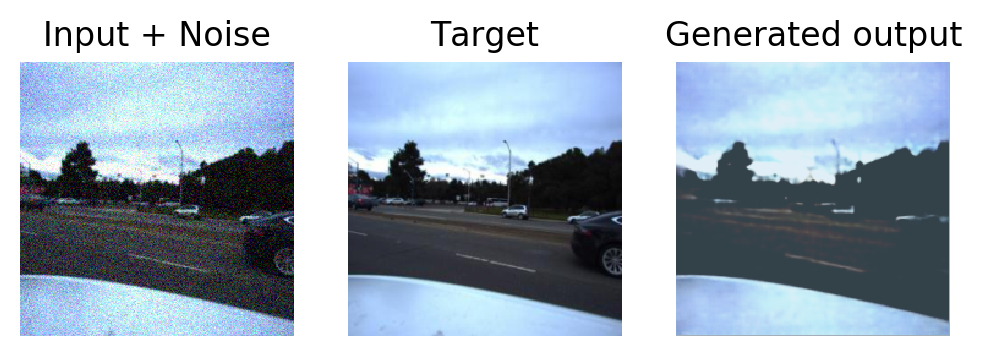

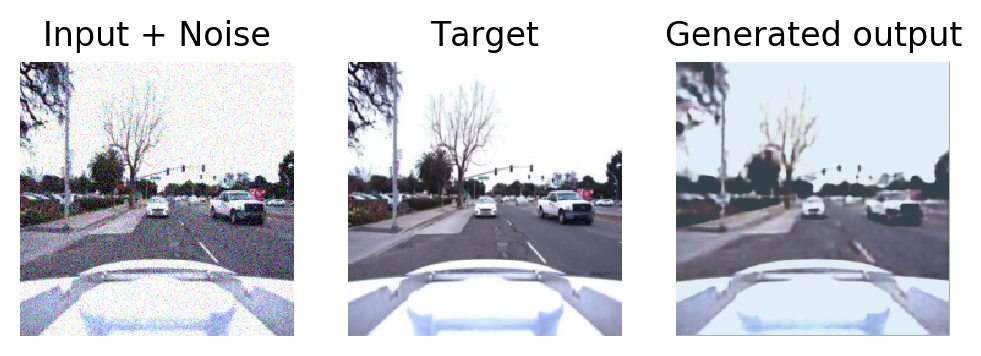

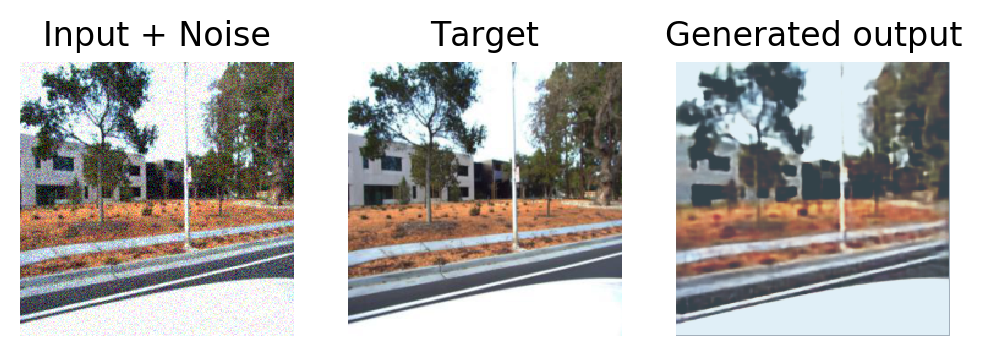

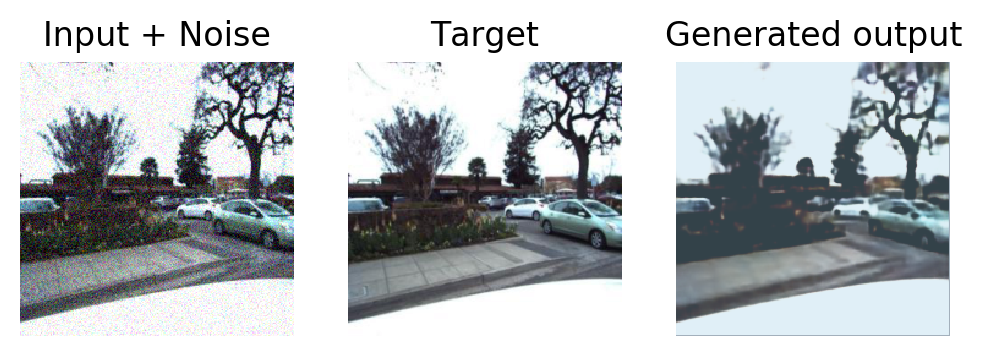

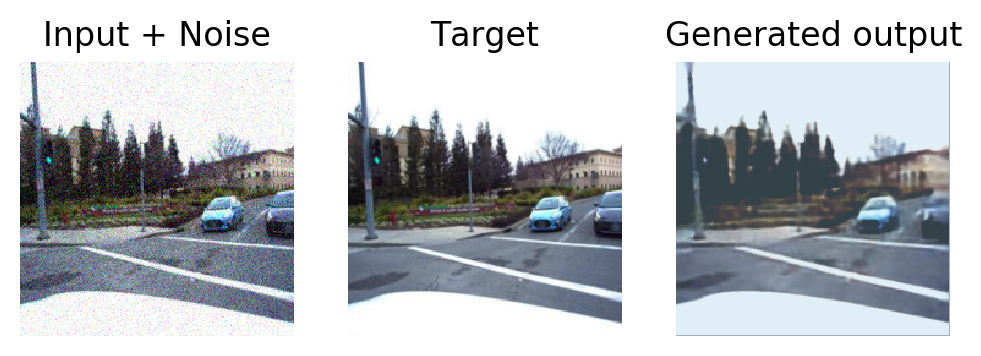

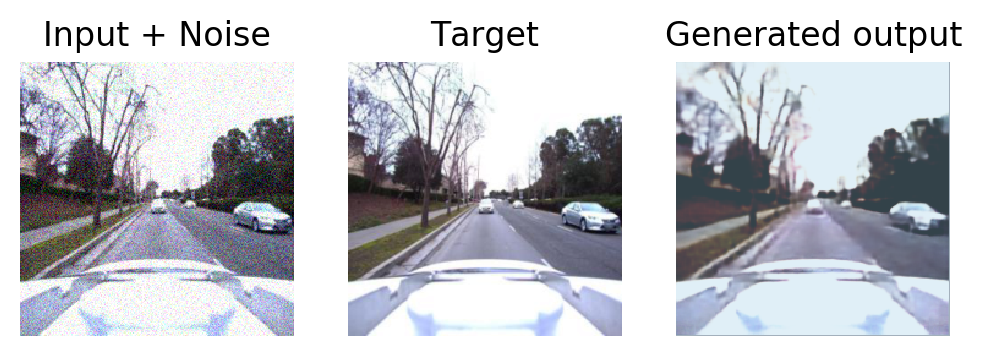

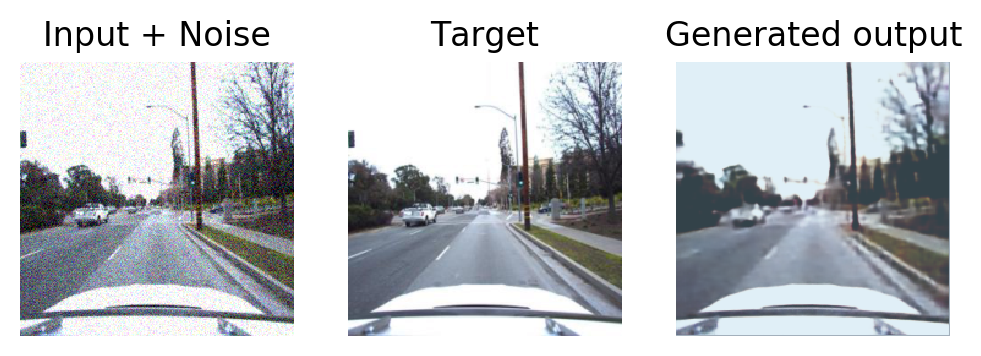

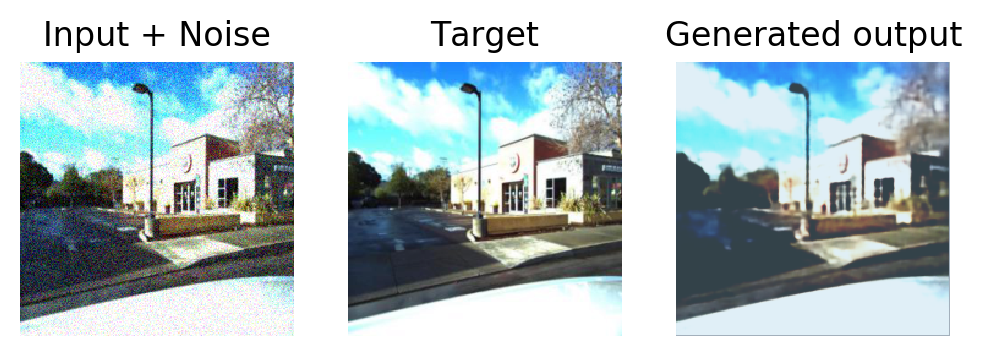

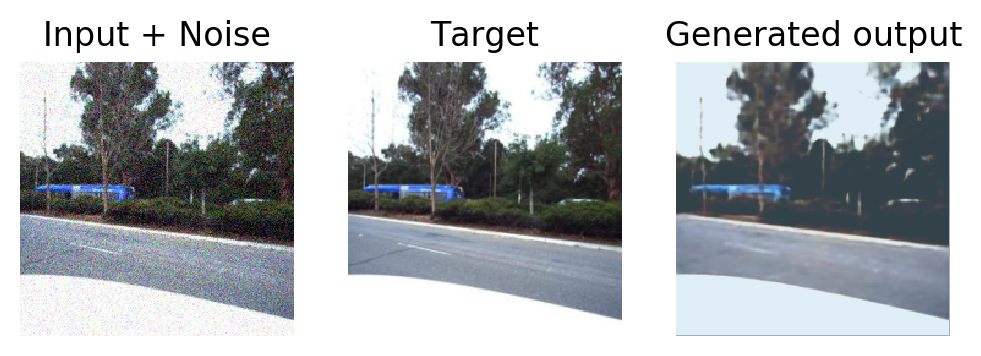

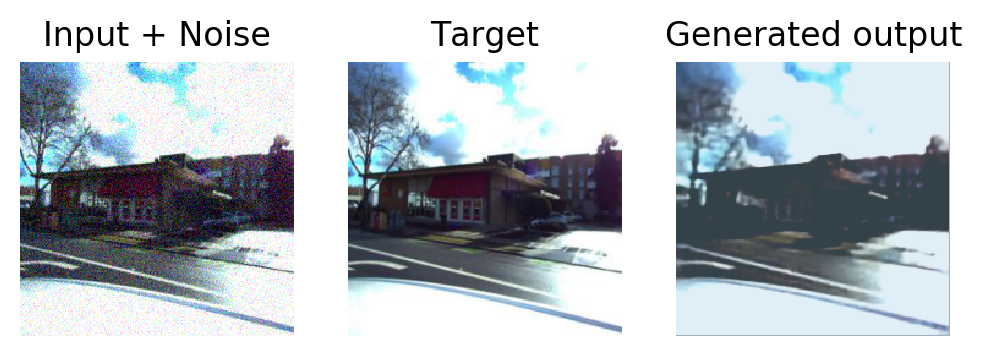

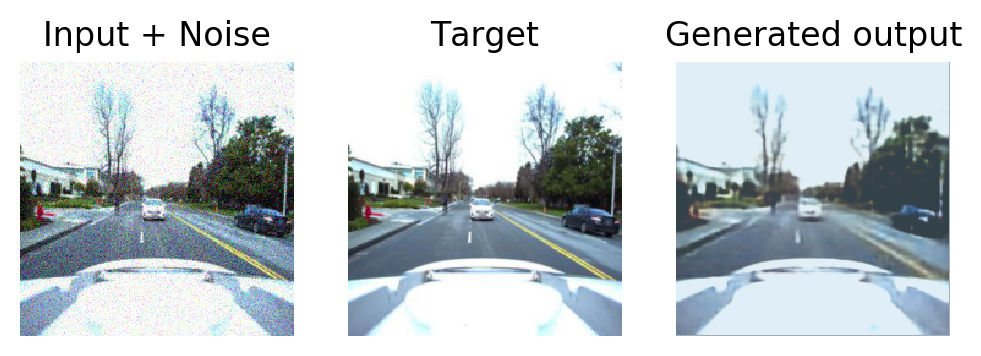

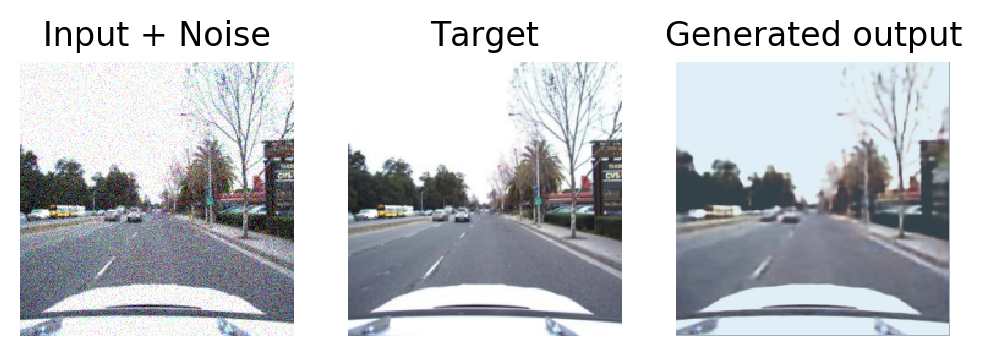

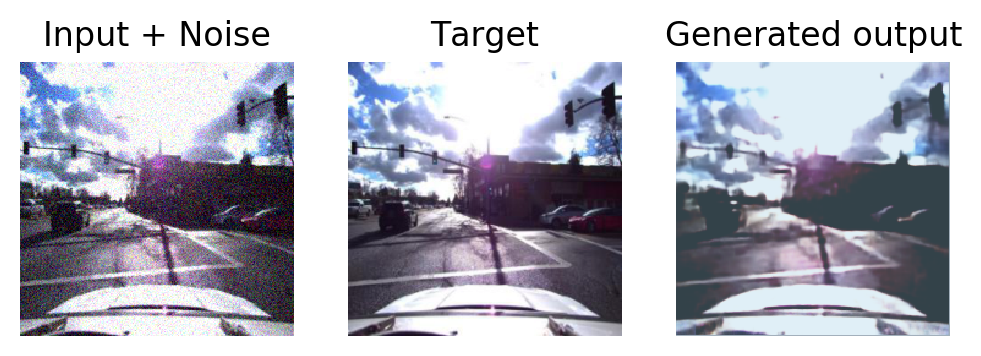

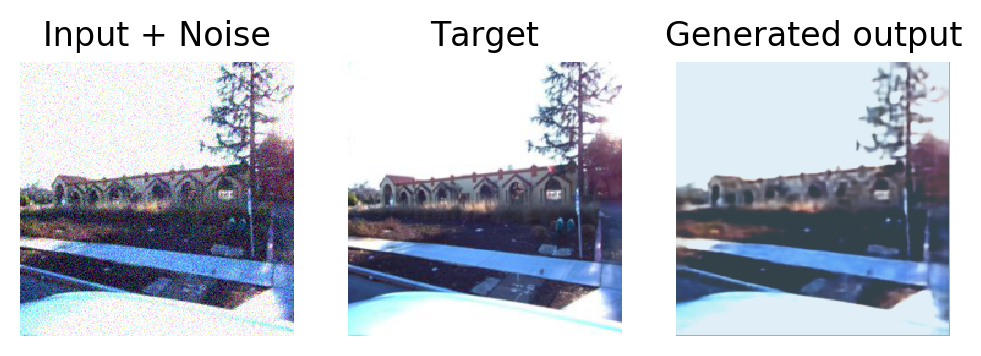

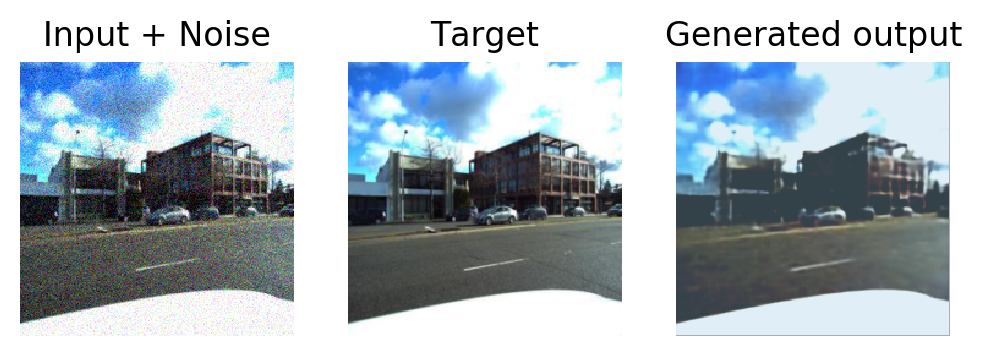

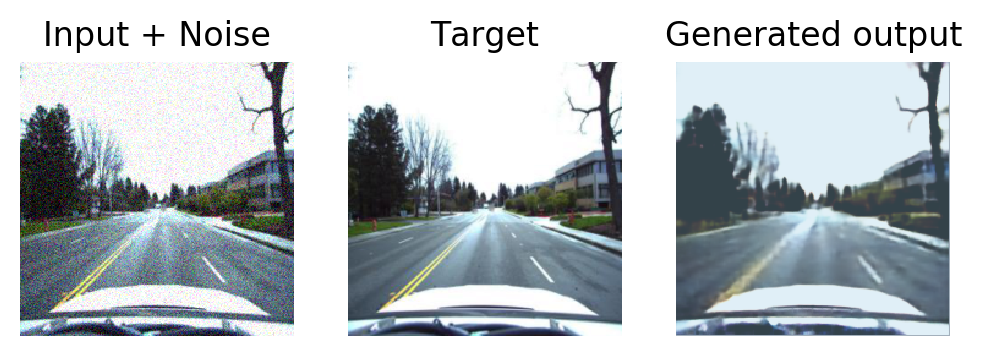

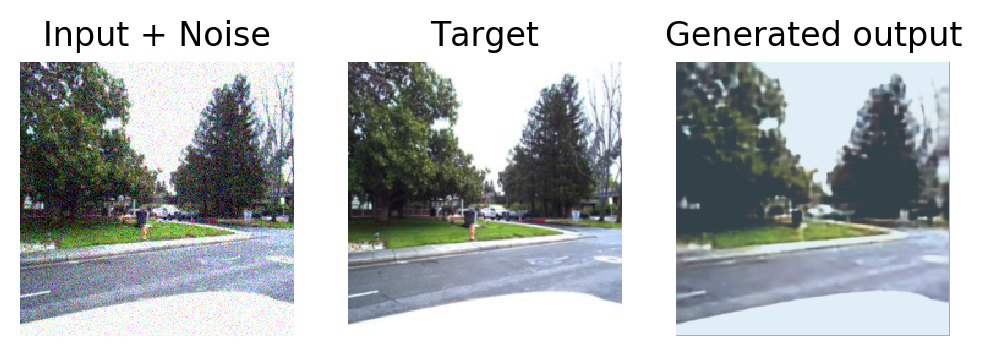

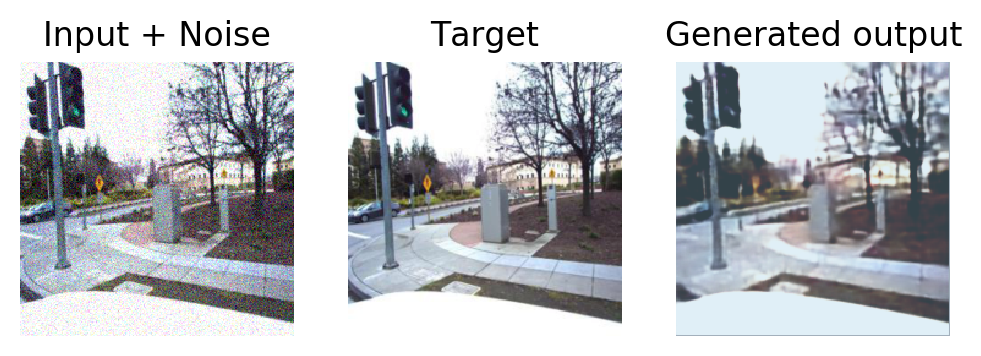

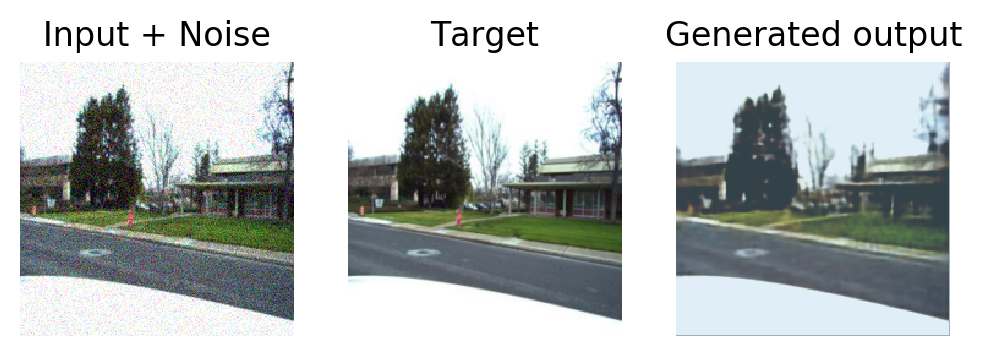

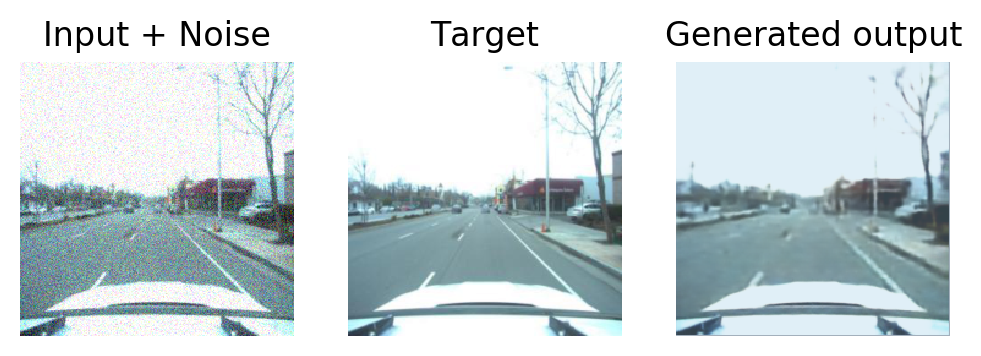

In [11]:
num_samples = 20

sample_idxs = np.random.choice(hparams.BATCH_SIZE // 2, num_samples, False)
for sample_idx in sample_idxs:
    plt.figure(figsize=(6, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(sample_input[sample_idx].numpy().transpose(1, 2, 0))
    plt.title("Input + Noise")
    plt.axis('off');

    plt.subplot(1, 3, 2)
    plt.imshow(sample_target[sample_idx].numpy().transpose(1, 2, 0))
    plt.title("Target")
    plt.axis('off');

    plt.subplot(1, 3, 3)
    plt.imshow(sample_output[sample_idx].numpy().transpose(1, 2, 0))
    plt.title("Generated output")
    plt.axis('off');
    
    plt.show()